In [601]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime
import math
import scipy.stats as ss

In [602]:
pd.read_parquet("../../data/website/databricks/hourly2/aug2019.parquet").drop_duplicates()

,timestamp,domain,trafficType,accessType,y,x
0,1566896400,ru.wikipedia,spider,desktop,4,40
1,1566889200,ru.wikipedia,spider,mobile-web,1,3241
2,1566882000,en.wikipedia,spider,desktop,10,61
3,1566871200,en.wikipedia,spider,desktop,14,14
4,1566864000,en.wikipedia,user,desktop,3,330
...,...,...,...,...,...,...
463375,1567274400,es.wikipedia,user,mobile-web,37,1
463376,1567260000,es.wikipedia,user,mobile-web,5108,1
463377,1567252800,es.wikipedia,user,desktop,8,1
463378,1567252800,de.wikipedia,user,mobile-app,76,1


In [603]:
df = pd.concat([
    pd.read_parquet("../../data/website/databricks/hourly2/aug2019.parquet").drop_duplicates(),
    pd.read_parquet("../../data/website/databricks/hourly2/sep2019.parquet").drop_duplicates(),
    pd.read_parquet("../../data/website/databricks/hourly2/oct2019.parquet").drop_duplicates(),
], axis=0, ignore_index=True)

df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df

,timestamp,domain,trafficType,accessType,y,x,date
0,1566896400,ru.wikipedia,spider,desktop,4,40,2019-08-27 09:00:00
1,1566889200,ru.wikipedia,spider,mobile-web,1,3241,2019-08-27 07:00:00
2,1566882000,en.wikipedia,spider,desktop,10,61,2019-08-27 05:00:00
3,1566871200,en.wikipedia,spider,desktop,14,14,2019-08-27 02:00:00
4,1566864000,en.wikipedia,user,desktop,3,330,2019-08-27 00:00:00
...,...,...,...,...,...,...,...
1099125,1570154400,ru.wikipedia,user,mobile-web,9,1,2019-10-04 02:00:00
1099126,1570179600,en.wikipedia,user,desktop,36,4,2019-10-04 09:00:00
1099127,1570136400,de.wikipedia,user,mobile-app,562,1,2019-10-03 21:00:00
1099128,1570140000,en.wikipedia,user,mobile-web,13596,1,2019-10-03 22:00:00


In [604]:
def bucketmaker(df, buckets):

    binstarts = buckets
    binends = np.roll(binstarts, -1)
    binends[-1] = np.inf
    occurences = np.zeros_like(binstarts)

    for _, (x, y) in df[["x", "y"]].iterrows():
        for i, (start, end) in enumerate(zip(binstarts, binends)):
            if (y >= start) and (y < end):
                occurences[i] += x

    probabilities = occurences / np.sum(occurences)

    return probabilities

In [606]:
def bucketmaker_np(df, buckets):
    dist = []

    for _, (x, y) in df[["x", "y"]].iterrows():
        dist += [y] * x

    logdist = np.log10(dist)

    hist = np.histogram(logdist, bins=len(buckets), range=(np.log10(min(buckets)), np.log10(max(buckets))), density=False)

    occurences, bins = hist
    probability = occurences/np.sum(occurences)

    return probability

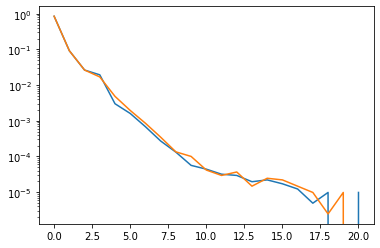

In [607]:
smalldf = df[df["timestamp"] == 1566896400]

plt.plot(bucketmaker(smalldf, np.logspace(0,4,21)))
plt.plot(bucketmaker_np(smalldf, np.logspace(0,4,21)))
plt.yscale("log")
plt.show()

# print(np.allclose(bucketmaker(smalldf), bucketmaker_np(smalldf)))

# %timeit bucketmaker(smalldf)
# %timeit bucketmaker_np(smalldf)
# plt.yscale("log")

The buckets below are not perfect, they dont really match the dist

maybe lets use the custom buckets:

idea 1: 1,2,3,4,5,6,7,8,9, 10,20,30, ..., 100, 200, 300, .., 1000, 2000, 3000, ...

or lets use something like:

[1 or higher ] [2 or higher] [3 or higher], [3 or higher], ... [1000 or higher]

so a dist like
1,1,1,1,1000000 gets a higher weight than 1,1,1,1,100
even though with above buckets they would not get

In [608]:
buckets = np.logspace(0,5,21)

probdf = df.groupby(["domain", "trafficType", "date"]).apply(bucketmaker, buckets).reset_index()
probdf[[f"self_{i:.3f}" for i in buckets]] = probdf.apply(lambda row: row[0], axis=1, result_type="expand")
probdf.drop(columns=0, inplace=True)
probdf

,domain,trafficType,date,self_1.000,self_1.778,self_3.162,self_5.623,self_10.000,self_17.783,self_31.623,...,self_562.341,self_1000.000,self_1778.279,self_3162.278,self_5623.413,self_10000.000,self_17782.794,self_31622.777,self_56234.133,self_100000.000
0,de.wikipedia,spider,2019-08-01 00:00:00,0.970863,0.026488,0.001394,0.000558,0.000279,0.000139,0.000139,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,de.wikipedia,spider,2019-08-01 01:00:00,0.962920,0.034636,0.001150,0.000719,0.000287,0.000000,0.000144,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,de.wikipedia,spider,2019-08-01 02:00:00,0.973563,0.021213,0.002533,0.002058,0.000317,0.000000,0.000158,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,de.wikipedia,spider,2019-08-01 03:00:00,0.969480,0.025851,0.002335,0.001501,0.000500,0.000000,0.000167,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,de.wikipedia,spider,2019-08-01 04:00:00,0.971706,0.024797,0.001590,0.000795,0.000636,0.000159,0.000159,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21019,zh.wikipedia,user,2019-10-12 19:00:00,0.916528,0.051753,0.005843,0.018364,0.000835,0.000835,0.001669,...,0.000000,0.000000,0.000000,0.000835,0.0,0.0,0.0,0.0,0.0,0.0
21020,zh.wikipedia,user,2019-10-12 20:00:00,0.900605,0.065687,0.012965,0.013829,0.000864,0.001729,0.000000,...,0.000000,0.000864,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21021,zh.wikipedia,user,2019-10-12 21:00:00,0.914749,0.048593,0.008525,0.017903,0.001705,0.003410,0.000853,...,0.000853,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21022,zh.wikipedia,user,2019-10-12 22:00:00,0.926790,0.038616,0.004827,0.023331,0.000805,0.000805,0.000805,...,0.000805,0.000000,0.000805,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [609]:
# KULLBACK-LEIBLER DIVERGENCE -- CHECKED
def KLD_dis(x, y, logbase=2):
    """Discrete kullback-Leibler divergence D(P(x)||Q(x)) for X, Y values stored in
    two arrays:
    - NOTE: there should be no events in x array that do not occur in y array
    - x: array with samples
    - y: array with samples
    - logbase: the base for the shannon entropy units
    """
    assert len(x) == len(y), "Arrays x and y have mismatching dimensions."

    # determining P(x)
    unique_x, count_x = np.unique(x, return_counts = True, axis=0)
    p_x = count_x / len(x)
    p_x = p_x[p_x > 0]

    # calculating the occurence of x in events in array y - Q(x)
    count_y = np.zeros((len(unique_x)))
    for i, x_val in enumerate(unique_x): # not the most efficient way, maybe there is a smarter way to 
        count_y[i] = np.count_nonzero(y == x_val)

    q_x = count_y/ len(y)
    q_x = q_x[q_x > 0]

    assert len(q_x) == len(p_x), "P(x) and Q(x) have mismatching dimensions."

    kl = np.sum(p_x * (np.log(p_x/q_x) / np.log(logbase)))
    return kl

In [610]:
def chisquared_distance(A, B):
    summ = 0
    for a,b in zip(A, B):
        if (a + b) == 0:
            continue
        val = ((a - b) ** 2) / (a + b)
        if val == np.nan:
            continue
        summ += val
    chi = 0.5 * summ
    return chi

In [611]:
# att_df = grouped_df[ ((grouped_df.date.dt.year == 2019) & (grouped_df.date.dt.month == 9) & (grouped_df.date.dt.day == 6))]
# ref_df = grouped_df[~((grouped_df.date.dt.year == 2019) & (grouped_df.date.dt.month == 9) & (grouped_df.date.dt.day == 6))]

# print(att_df.shape)
# print(ref_df.shape)

# # for attack we only have 1 day, so mean() does not do anything, however we still need to give a 'dummy' function to 
# # transform the groupby into a dataframe
# att_df = att_df.groupby(["domain", att_df.date.dt.hour]).mean().reset_index().rename(columns={"date":"hour"})
# # for reference, group by all 24 hours, then take mean probability across all 50 or so days
# ref_df = ref_df.groupby(["domain", ref_df.date.dt.hour]).mean().reset_index().rename(columns={"date":"hour"})

# print(att_df.shape)
# print(ref_df.shape)

In [612]:
probdf[[f"ref_{i:.3f}" for i in buckets]] = np.nan
self_buckets = [i for i in probdf.columns if "self" in i]
ref_buckets = [i for i in probdf.columns if "ref" in i]

In [614]:
for idx, (dom, tt, date, *_) in probdf.iterrows():
    if idx%1000 == 0: print(idx, end="")
    probdf.loc[idx, ref_buckets] = probdf.loc[
        (
            # exclude attack i.e. include any day where at least of of the statements below is False, and for
            # attack day they are all true
            ((probdf.date.dt.year != 2019) | (probdf.date.dt.month != 9) | (probdf.date.dt.day != 6)) &
            # exclude day after attack
            ((probdf.date.dt.year != 2019) | (probdf.date.dt.month != 9) | (probdf.date.dt.day != 7)) &
            # exlude same day
            (probdf.date != date) &
            # only take same hour 
            (probdf.date.dt.hour == date.hour) &
            # only same domain
            (probdf.domain == dom) &
            # only same traffictype
            (probdf.trafficType == tt)
        ), self_buckets
    ].mean(axis=0).to_numpy()  # to_numpy to get rid of the self_buckets columns

0100020003000400050006000700080009000100001100012000130001400015000160001700018000190002000021000

In [615]:
# probdf.to_csv("../../data/small/quantitative/probdf1.csv")

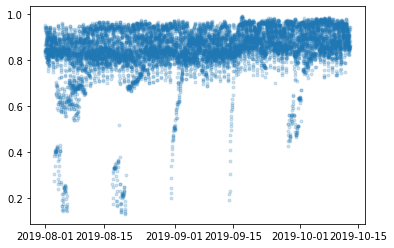

In [554]:
plt.scatter(probdf.date, probdf["self_1.000"], marker=".", alpha=0.2)

In [557]:
probdf.iloc[probdf["self_1.000"].argmin()]

domain                    fr.wikipedia
date               2019-08-20 03:00:00
self_1.000                    0.130368
self_1.778                    0.862226
self_3.162                    0.006478
self_5.623                    0.000547
self_10.000                   0.000152
self_17.783                   0.000061
self_31.623                   0.000046
self_56.234                   0.000046
self_100.000                  0.000015
self_177.828                  0.000015
self_316.228                   0.00003
self_562.341                  0.000015
self_1000.000                      0.0
self_1778.279                      0.0
self_3162.278                      0.0
self_5623.413                      0.0
self_10000.000                     0.0
self_17782.794                     0.0
self_31622.777                     0.0
self_56234.133                     0.0
self_100000.000                    0.0
ref_1.000                     0.869195
ref_1.778                     0.112946
ref_3.162                

In [565]:
weird_df = df[(df["domain"]=="fr.wikipedia") & (df["date"]==datetime.datetime(2019, 8, 20, 3, 0, 0))]
weird_df.sort_values("y").head(15)

,timestamp,domain,trafficType,accessType,y,x,date
250474,1566270000,fr.wikipedia,user,mobile-app,1,1501,2019-08-20 03:00:00
345821,1566270000,fr.wikipedia,spider,desktop,1,3721,2019-08-20 03:00:00
215457,1566270000,fr.wikipedia,user,desktop,1,366,2019-08-20 03:00:00
200527,1566270000,fr.wikipedia,spider,mobile-web,1,2091,2019-08-20 03:00:00
125511,1566270000,fr.wikipedia,user,mobile-web,1,894,2019-08-20 03:00:00
273282,1566270000,fr.wikipedia,user,mobile-app,2,387,2019-08-20 03:00:00
171250,1566270000,fr.wikipedia,user,mobile-web,2,110,2019-08-20 03:00:00
127901,1566270000,fr.wikipedia,spider,mobile-web,2,38,2019-08-20 03:00:00
115718,1566270000,fr.wikipedia,user,desktop,2,59,2019-08-20 03:00:00
459568,1566270000,fr.wikipedia,spider,desktop,2,55942,2019-08-20 03:00:00


# The weird thing are webcrawlers at night!

In [619]:
metric_df = probdf[["domain", "date", "trafficType"]]
metric_df["self_entropy"] = np.nan
metric_df["ref_entropy"] = np.nan
metric_df["kl"] = np.nan
metric_df["chi"] = np.nan
# metric_df["size"] = np.nan

In [620]:
for idx, row in probdf.iterrows():
    if idx%1000 == 0: print(idx, end="")

    self_dist = row[self_buckets].to_numpy(dtype="float64")
    ref_dist = row[ref_buckets].to_numpy(dtype="float64")

    metric_df.loc[idx, "self_entropy"] = ss.entropy(self_dist, base=2)
    metric_df.loc[idx, "ref_entropy"] = ss.entropy(ref_dist, base=2)
    metric_df.loc[idx, "chi"] = chisquared_distance(self_dist, ref_dist)
    metric_df.loc[idx, "kl"] = ss.entropy(self_dist, ref_dist, base=2)

0100020003000400050006000700080009000100001100012000130001400015000160001700018000190002000021000

In [621]:
# metric_df.to_csv("../../data/small/quantitative/metric1.csv")
metric_df

,domain,date,trafficType,self_entropy,ref_entropy,kl,chi
0,de.wikipedia,2019-08-01 00:00:00,spider,0.208078,0.354946,0.020634,0.007701
1,de.wikipedia,2019-08-01 01:00:00,spider,0.246312,0.353819,0.011005,0.004020
2,de.wikipedia,2019-08-01 02:00:00,spider,0.203441,0.515024,0.087726,0.032761
3,de.wikipedia,2019-08-01 03:00:00,spider,0.223844,0.524793,0.081557,0.030450
4,de.wikipedia,2019-08-01 04:00:00,spider,0.208230,0.525042,0.080272,0.030534
...,...,...,...,...,...,...,...
21019,zh.wikipedia,2019-10-12 19:00:00,user,0.556795,0.852757,0.092224,0.032598
21020,zh.wikipedia,2019-10-12 20:00:00,user,0.625921,0.808271,0.069195,0.023332
21021,zh.wikipedia,2019-10-12 21:00:00,user,0.583844,0.837920,0.097057,0.034014
21022,zh.wikipedia,2019-10-12 22:00:00,user,0.508912,0.830114,inf,0.044760


In [622]:
# plt.figure(figsize=(10, 2))
# plt.scatter(ref_days_df["date"], [1]*len(ref_days_df["date"]), marker=".")
# daterange = pd.date_range(start = ref_days_df["date"].min(), end = ref_days_df["date"].max())
# plt.scatter(daterange, [2]*len(daterange), marker=".")
# plt.grid()

In [625]:
ref_days_df = metric_df.loc[(
    ((metric_df.date.dt.year != 2019) | (metric_df.date.dt.month != 9) | (metric_df.date.dt.day != 6)) &
    ((metric_df.date.dt.year != 2019) | (metric_df.date.dt.month != 9) | (metric_df.date.dt.day != 7)))]

attack_day_df = metric_df.loc[(metric_df.date.dt.year == 2019) & (metric_df.date.dt.month == 9) & (metric_df.date.dt.day == 6)]

ref_days_df = ref_days_df.replace([np.inf, -np.inf], np.nan).dropna()  # todo: remove NAN at prior step

attack_day_grouped = attack_day_df.groupby(["domain", "trafficType", attack_day_df.date.dt.hour]).mean().reset_index()
attack_day_grouped.rename(columns={"date":"hour"}, inplace=True)
ref_days_grouped_mean = ref_days_df.groupby(["domain", "trafficType", ref_days_df.date.dt.hour]).mean().reset_index()
ref_days_grouped_std = ref_days_df.groupby(["domain", "trafficType", ref_days_df.date.dt.hour]).std().reset_index()
ref_days_grouped_mean.rename(columns={"date":"hour"}, inplace=True)
ref_days_grouped_std.rename(columns={"date":"hour"}, inplace=True)

ref_days_grouped_CI = ref_days_grouped_std.copy()
ref_days_grouped_CI["self_entropy"] = 2.58 * (ref_days_grouped_CI["self_entropy"]) / math.sqrt((len(daterange) - 2))
ref_days_grouped_CI["ref_entropy"] = 2.58 * (ref_days_grouped_CI["ref_entropy"]) / math.sqrt((len(daterange) - 2))
ref_days_grouped_CI["kl"] = 2.58 * (ref_days_grouped_CI["kl"]) / math.sqrt((len(daterange) - 2))
ref_days_grouped_CI["chi"] = 2.58 * (ref_days_grouped_CI["chi"]) / math.sqrt((len(daterange) - 2))

array(['ru.wikipedia', 'en.wikipedia', 'es.wikipedia', 'de.wikipedia',
       'fr.wikipedia', 'zh.wikipedia'], dtype=object)

In [672]:
for domain in df["domain"].unique():
    for tt in ["spider", "user"]:
        for metric in ["kl", "chi", "self_entropy"]:

            x = attack_day_grouped[(attack_day_grouped["domain"] == domain) & (attack_day_grouped["trafficType"] == tt)]["hour"]
            attack_metric = attack_day_grouped[(attack_day_grouped["domain"] == domain) & (attack_day_grouped["trafficType"] == tt)][metric]
            ref_mean_metric = ref_days_grouped_mean[(ref_days_grouped_mean["domain"] == domain) & (ref_days_grouped_mean["trafficType"] == tt)][metric]
            ref_ci_metric = ref_days_grouped_CI[(ref_days_grouped_CI["domain"] == domain) & (ref_days_grouped_CI["trafficType"] == tt)][metric]

            if metric == "self_entropy": metric = "entropy"
            unit = metric
            if metric == "kl": unit = "bits"
            if metric == "chi": unit = "distance"
            if metric == "entropy": unit = "bits"

            name = f"{domain} - {tt} - {metric}"

            plt.figure()
            plt.title(name)
            plt.plot(x, attack_metric, label=f"{metric} during attack day (2019-09-06)", color="red")
            plt.plot(x, ref_mean_metric, label=f"mean {metric} (reference)", color="C0")
            plt.fill_between(x, ref_mean_metric-ref_ci_metric, ref_mean_metric+ref_ci_metric, label=f"mean $\pm$ 99% C.I. {metric} (reference)", alpha=0.15, color="C0")
            plt.xticks([0, 6, 12, 15,16, 17, 18,19,20,21, 23], labels=[0, 6, 12, 15,16, 17, 18,19,20,21, 23])
            plt.legend()
            plt.grid(linestyle="--", alpha=0.4)
            plt.xlabel("hour")
            plt.ylabel(unit)
            plt.tight_layout()
            plt.savefig(f"../../img/quantitative_metrics_pdf/{name}.pdf".replace(" ", "_"), dpi=300)
            plt.close()
            # plt.show()

In [671]:
for domain in df["domain"].unique():
    for tt in ["spider", "user"]:
        for metric in ["kl", "chi", "self_entropy"]:

            ref_filter = ref_days_df[(ref_days_df["domain"] == domain) & (ref_days_df["trafficType"] == tt)]
            att_filter = attack_day_df[(attack_day_df["domain"] == domain) & (attack_day_df["trafficType"] == tt)]
            # [metric]

            metric_name = metric
            if metric == "self_entropy": metric_name = "entropy"
            unit = metric
            if metric_name == "kl": unit = "bits"
            if metric_name == "chi": unit = "distance"
            if metric_name == "entropy": unit = "bits"

            name = f"{domain} - {tt} - {metric_name}"

            plt.figure()
            plt.scatter(ref_filter["date"], ref_filter[metric], marker=".", alpha=0.5, label=f"{metric_name} (reference)")
            plt.scatter(att_filter["date"], att_filter[metric], color="red", marker=".", alpha=0.5, label=f"{metric_name} (2019-09-06)")
            plt.yscale("log")
            plt.title(name)
            plt.legend()
            plt.grid(linestyle="--", alpha=0.4)
            plt.xlabel("time")
            plt.ylabel(unit)
            plt.tight_layout()
            # plt.xticks(
            #     [
            #         datetime.datetime(2019,8,1),
            #         datetime.datetime(2019,8,15),
            #         datetime.datetime(2019,9,1)
            #     ], labels=[
            #         "August 1st"
            #     ]
            # )
            plt.savefig(f"../../img/quantitative_metrics_2_pdf/day_{name}.pdf".replace(" ", "_"), dpi=300)
            plt.close()
            # plt.show()

In [735]:
probdf

user ru.wikipedia
spider ru.wikipedia


KeyboardInterrupt: 

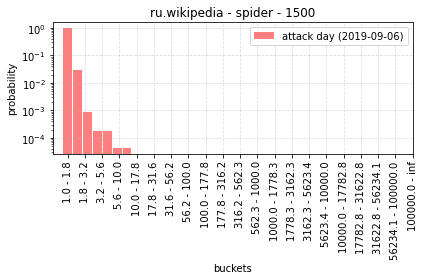

In [787]:
for domain in ["de.wikipedia", "en.wikipedia"]:
    for tt in ["user", "spider"]:
        print(tt, domain)

        histdf = probdf[(probdf["domain"] == domain) & (probdf["trafficType"] == tt)]

        attack_filter = (probdf.date.dt.year == 2019) & (probdf.date.dt.month == 9) & (probdf.date.dt.day == 6)

        other_filter = (probdf.date.dt.year == 2019) & (probdf.date.dt.month == 9) & (probdf.date.dt.day == 3)

        att_df = histdf.loc[(attack_filter), self_buckets]
        other_df = histdf.loc[(other_filter), self_buckets]

        end_buckets = np.roll(buckets, -1)
        end_buckets[-1] = np.inf

        for hour, (_, row1), (_, row2) in zip(range(24), att_df.iterrows(), other_df.iterrows()):

            if hour < 12: continue

            name = f"{domain} - {tt} - {hour:02d}00"
            plt.title(name)
            plt.bar(np.log(buckets), row1, label="attack day (2019-09-06)", alpha=0.5, color="red", width=0.5)
            plt.bar(np.log(buckets), row2, label="other day (2019-09-03)", alpha=0.5, color="C0", width=0.5)
            plt.xticks(np.arange(len(buckets)), [f"{i:.1f} - {j:.1f}" for i,j in zip(buckets, end_buckets)], rotation=90)
            plt.yscale("log")
            plt.legend()
            plt.grid(linestyle="--", alpha=0.4)
            plt.xlabel("buckets")
            plt.ylabel("probability")
            plt.tight_layout()
            plt.savefig(f"../../img/distributions/dist_2days_{name}.pdf".replace(" ", "_"), dpi=300)
            plt.close()

            name = f"{domain} - {tt} - {hour:02d}00"
            plt.title(name)
            plt.bar(np.log(buckets), row1, label="attack day (2019-09-06)", alpha=0.5, color="red", width=0.5)
            plt.xticks(np.arange(len(buckets)), [f"{i:.1f} - {j:.1f}" for i,j in zip(buckets, end_buckets)], rotation=90)
            plt.yscale("log")
            plt.legend()
            plt.grid(linestyle="--", alpha=0.4)
            plt.xlabel("buckets")
            plt.ylabel("probability")
            plt.tight_layout()
            plt.savefig(f"../../img/distributions/dist_1day_{name}.pdf".replace(" ", "_"), dpi=300)
            plt.close()

        # 8/0


In [766]:
buckets

array([1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01, 5.62341325e+01,
       1.00000000e+02, 1.77827941e+02, 3.16227766e+02, 5.62341325e+02,
       1.00000000e+03, 1.77827941e+03, 3.16227766e+03, 5.62341325e+03,
       1.00000000e+04, 1.77827941e+04, 3.16227766e+04, 5.62341325e+04,
       1.00000000e+05])

In [754]:
row

self_1.000         0.826616
self_1.778         0.148289
self_3.162         0.015716
self_5.623         0.005577
self_10.000        0.001014
self_17.783        0.000760
self_31.623        0.000507
self_56.234        0.000507
self_100.000       0.000000
self_177.828       0.000760
self_316.228       0.000000
self_562.341       0.000253
self_1000.000      0.000000
self_1778.279      0.000000
self_3162.278      0.000000
self_5623.413      0.000000
self_10000.000     0.000000
self_17782.794     0.000000
self_31622.777     0.000000
self_56234.133     0.000000
self_100000.000    0.000000
Name: 16632, dtype: float64

ZeroDivisionError: division by zero

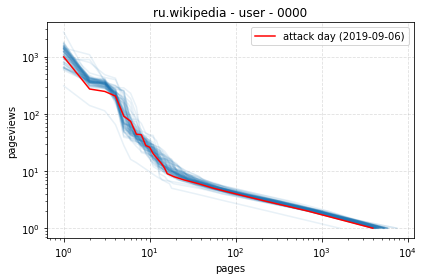

In [729]:
for domain in df["domain"].unique():
    for tt in ["user", "spider"]:
        for hour in range(24):

            plotdf = df[(df.domain == domain) & (df.trafficType == tt) & (df.date.dt.hour == hour)]
            plotdf.drop(columns="timestamp", inplace=True)

            plotdf = plotdf.groupby(["date", "y"]).sum().reset_index()

            attack_filter = (plotdf.date.dt.year == 2019) & (plotdf.date.dt.month == 9) & (plotdf.date.dt.day == 6)

            attack_plot_df = plotdf[attack_filter]
            ref_plot_df = plotdf[~attack_filter]

            attack_plot_group = attack_plot_df.groupby("y").mean().sort_values("y", ascending=False).reset_index()


            ref_plot_group_mean = ref_plot_df.groupby("y").mean().sort_values("y", ascending=False).reset_index()
            ref_plot_group_std = ref_plot_df.groupby("y").std().sort_values("y", ascending=False).reset_index()


            plt.figure()
            for date in [pd.Timestamp(i) for i in ref_plot_df.date.unique()]:
                filter_ref_group = ref_plot_df[ref_plot_df.date == date].groupby("y").mean().sort_values("y", ascending=False).reset_index()
                x_ref = np.cumsum(filter_ref_group["x"])
                y_red = filter_ref_group["y"].to_numpy()
                plt.plot(x_ref, y_red, color="C0", alpha=0.1)




            x_att = np.cumsum(attack_plot_group["x"])
            y_att = attack_plot_group["y"].to_numpy()

            name = f"{domain} - {tt} - {hour:02d}00"

            
            plt.plot(x_att, y_att, color="red", label="attack day (2019-09-06)")
            plt.xscale("log")
            plt.yscale("log")
            plt.title(name)
            plt.legend()
            plt.grid(linestyle="--", alpha=0.4)
            plt.xlabel("pages")
            plt.ylabel("pageviews")
            plt.tight_layout()
            # plt.savefig(f"../../img/quantitative_metrics_2_pdf/day_{name}.pdf".replace(" ", "_"), dpi=300)
            # plt.close()
            

            # y = plotdf["y"]



            8/0

        

In [733]:
ref_plot_df.groupby("y").mean()

,x
y,
1,3971.555556
2,578.972222
3,148.111111
4,49.222222
5,20.375000
...,...
1696,1.000000
1716,1.000000
1722,1.000000


In [718]:
ref_plot_group_mean

,y,x
0,231,1.000000
1,115,1.000000
2,98,1.000000
3,94,1.000000
4,87,1.000000
5,57,1.000000
6,49,1.000000
7,45,1.000000
8,44,1.000000
9,43,1.000000
